In [2]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from HRIRDataset import HRIRDataset
from StraightPredictor import StraightPredictor
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
from torch.optim.lr_scheduler import StepLR

# Train FullSeqModel
from FullSeqModel import FullSeqModel

device = torch.device('cuda')


sp_model = StraightPredictor()
sp_model = sp_model.to(device)
sp_model.train()
# Define the optimizer and loss function
optimizer = optim.Adam(sp_model.parameters())
loss_function = nn.MSELoss(reduction='none')
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)


target_folder = '/workspace/fourth_year_project/HRTF Models/teststraight_models/'
# Create it if it doesn't exist
import os
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
hrir_dataset = HRIRDataset()
for i in range(1,50):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

print(len(hrir_dataset))

from torch.utils.data import DataLoader
import torch

num_epochs = 400


# Split the dataset into a training, validation and test set
# 0.8, 0.1, 0.1 respectively
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.15 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])


# model.load_state_dict(torch.load('/workspace/fourth_year_project/HRTF Models/mask_models/model_4.pth'))
batch_size = 64

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)


model = sp_model

/workspace/venv_work/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


3528


In [ ]:
# start from mask model
model.load_state_dict(torch.load('/workspace/fourth_year_project/HRTF Models/mask_models/model_98.pth'))
model = model.to(device)

In [4]:
import random

# Save a sample where the validation loss is low
# save_tgt = None
# save_angle = None
# save_src = None
# save_output = None

for epoch in range(1, num_epochs):
    # Initialize the epoch loss
    epoch_loss = 0.0
    no_tgt_loss = 0.0
    no_tgt_flag = False
    no_number = 0
    model.train()
    # Loop over half of the dataset
    # indices = torch.randperm(dataset_size)

    # Split the dataset into four parts
    # half_size = dataset_size // 4
    # first_half_indices = indices[:half_size]
    # fhd = torch.utils.data.Subset(train_dataset, first_half_indices)
    # dl = DataLoader(fhd, batch_size=batch_size, shuffle=True, num_workers=6)
    for i, batch in enumerate(dataloader):
        # Get the src and tgt sequences from the batch
        src, tgt, angle = batch
        # Move data to the same device as the model
        src = src.to(device)
        tgt = tgt.to(device)
        angle = angle.to(device)
        # convert to floats
        angle = angle.float()
        src = src.float()
        tgt = tgt.float()

        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass through the model

        # Standardize the input
        src = (src - src.mean()) / src.std()
        tgt = (tgt - tgt.mean()) / tgt.std()
        # Divide angle by 360 to get a value between 0 and 1
        angle = angle / 360

        # generate number between 0 and 1
        r = random.random()
        if r < 10.4:
            output = model(src, angle, tgt=tgt)
        else:
            output = model(src, angle)
            no_tgt_flag = True
        
        # remove the last feature dimension from output
        # [batch_size, d_model, seq_length] --> [batch_size, d_model-1, seq_length]
        output = output[:, :-1, :]

        
        loss = loss_function(output, tgt)
        # Add weight to elements between 50 and 200
        weight = torch.ones_like(tgt)
        weight[:, :, 50:200] = 4
        loss = loss * weight
        loss = loss.mean()

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the batch loss
        epoch_loss += loss.item()
        if no_tgt_flag:
            no_tgt_loss += loss.item()
            no_number += 1
            no_tgt_flag = False
        # print(f'Epoch {epoch} | Batch {i} | Loss: {loss.item()}')
    val_loss = 0
    scheduler.step()
    # Validate the model when with and without tgt
    # With tgt
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            src, tgt, angle = batch
            src = src.to(device)
            tgt = tgt.to(device)
            angle = angle.to(device)
            angle = angle.float()
            src = src.float()
            tgt = tgt.float()

            # Standardize the input
            src = (src - src.mean()) / src.std()
            tgt = (tgt - tgt.mean()) / tgt.std()
            # Divide angle by 360 to get a value between 0 and 1
            angle = angle / 360

            output = model(src, angle, tgt=tgt)
            # remove the last feature dimension from output
            output = output[:, :-1, :]
            #print("Before loss val: ",output.shape, tgt.shape)
            loss = loss_function(output, tgt)
            # Add weight to elements between 50 and 200
            weight = torch.ones_like(tgt)
            weight[:, :, 50:200] = 4
            loss = loss * weight
            loss = loss.mean()
            val_loss += loss.item()

    # without tgt
    test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            src, tgt, angle = batch
            src = src.to(device)
            angle = angle.to(device)
            tgt = tgt.to(device)
            tgt = tgt.float()
            angle = angle.float()
            src = src.float()

            # Standardize the input
            src = (src - src.mean()) / src.std()
            tgt = (tgt - tgt.mean()) / tgt.std()
            # Divide angle by 360 to get a value between 0 and 1
            angle = angle / 360

            output = model(src, angle)
            # remove the last feature dimension from output
            output = output[:, :-1, :]
            #print("Before loss val: ",output.shape, tgt.shape)
            loss = loss_function(output, tgt)
            # Add weight to elements between 50 and 200 in the sequence
            # [batch_size, d_model, seq_length]
            weight = torch.ones_like(tgt)
            weight[:, :, 50:200] = 4
            loss = loss * weight
            loss = loss.mean()

            if loss/batch_size < 0.1:
                save_tgt = tgt
                save_angle = angle
                save_src = src
                save_output = output
                # raise Exception("Low validation loss")
            test_loss += loss.item()
    # Print the average loss for this epoch
    print(f'Epoch {epoch} | Training Loss: {epoch_loss / len(dataloader)} | No TGT Train: {no_tgt_loss} | Validation (tgt): {val_loss / len(val_loader)} | Test (no tgt): {test_loss / len(val_loader)} | Learning Rate: {scheduler.get_last_lr()}')
    # if epoch % 25 == 0:
        # torch.save(model.state_dict(), f'{target_folder}model_{epoch}.pth')

Epoch 1 | Training Loss: 4.104414444703322 | No TGT Train: 0.0 | Validation (tgt): 3.8184407816992865 | Test (no tgt): 4.891487969292535 | Learning Rate: [0.001]
Epoch 2 | Training Loss: 3.8842161924411087 | No TGT Train: 0.0 | Validation (tgt): 3.629873938030667 | Test (no tgt): 4.713259167141384 | Learning Rate: [0.001]
Epoch 3 | Training Loss: 3.730956731698452 | No TGT Train: 0.0 | Validation (tgt): 3.4832854006025524 | Test (no tgt): 4.571605947282579 | Learning Rate: [0.001]
Epoch 4 | Training Loss: 3.6248708932827682 | No TGT Train: 0.0 | Validation (tgt): 3.4192901187472873 | Test (no tgt): 4.49423180686103 | Learning Rate: [0.001]
Epoch 5 | Training Loss: 3.5421330500871706 | No TGT Train: 0.0 | Validation (tgt): 3.3459528817070856 | Test (no tgt): 4.393435001373291 | Learning Rate: [0.001]
Epoch 6 | Training Loss: 3.471197012143257 | No TGT Train: 0.0 | Validation (tgt): 3.301591846677992 | Test (no tgt): 4.318313121795654 | Learning Rate: [0.001]
Epoch 7 | Training Loss: 3.4

KeyboardInterrupt: 

In [3]:
weight[0, 0, 50:200] 

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], device='cuda:0')

In [6]:
# model = StraightPredictor()
# model = model.to(device)
# model.load_state_dict(torch.load('/workspace/fourth_year_project/HRTF Models/full_seq_models/model_175.pth'))

save_tgt, save_angle, save_src, save_output = save_tgt.to('cpu'), save_angle.to('cpu'), save_src.to('cpu'), save_output.to('cpu')

In [7]:
print(save_tgt.shape, save_angle.shape, save_src.shape, save_output.shape)

torch.Size([64, 2, 512]) torch.Size([64]) torch.Size([64, 2, 512]) torch.Size([64, 2, 512])


In [8]:
index = 0

t1, s1, o1 = save_tgt[index,0,:], save_src[index,0,:], save_output[index,0,:]
print(t1.shape, s1.shape, o1.shape)

torch.Size([512]) torch.Size([512]) torch.Size([512])


In [12]:
print(loss_function(save_tgt, save_output).mean())

tensor(1.1652)


Text(0.5, 1.0, 'Output')

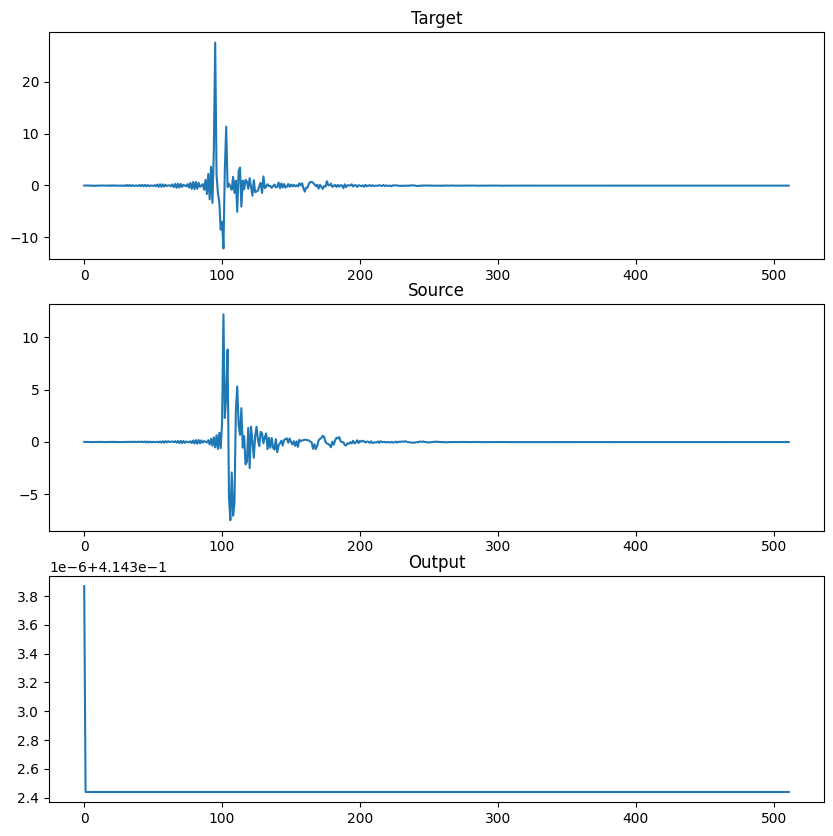

In [10]:
# Plot t1, s1, o1 on their own subplots
# create subplot
fig, ax = plt.subplots(3, 1, figsize=(10,10))


ax[0].plot(t1)
ax[0].set_title('Target')
ax[1].plot(s1)
ax[1].set_title('Source')
ax[2].plot(o1)
ax[2].set_title('Output')


In [25]:
# load in 1 sample from test set
sample = next(iter(dataloader))
src, tgt, angle = sample
src = src.to(device)
tgt = tgt.to(device)
angle = angle.to(device)
angle = angle.float()
src = src.float()
tgt = tgt.float()

# Get first sample from batch
src = src[0]
tgt = tgt[0]
angle = angle[0]

# Standardize the input
src = (src - src.mean()) / src.std()
tgt = (tgt - tgt.mean()) / tgt.std()
# Divide angle by 360 to get a value between 0 and 1
angle = angle / 360
test_loss_func = nn.MSELoss()

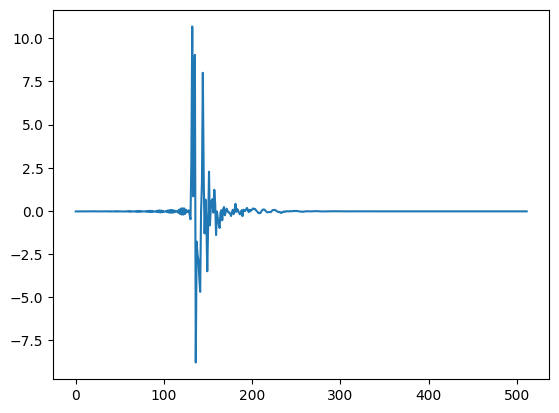

In [26]:
plt.plot(src[0].cpu().detach().numpy())


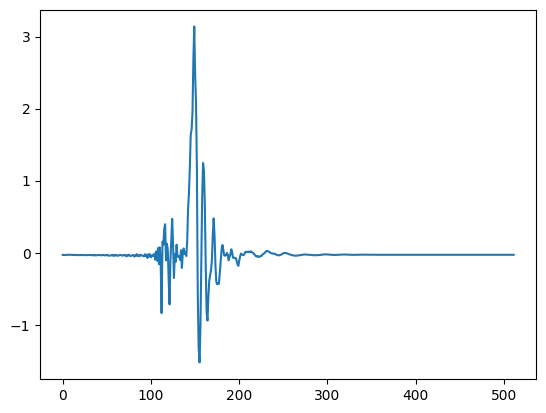

In [27]:
plt.plot(tgt[0].cpu().detach().numpy())

In [28]:
print(src.shape, angle.shape, tgt.shape)
print(angle)
# With target
output = model(src.unsqueeze(0), angle.unsqueeze(0), tgt=tgt.unsqueeze(0))
output  = output.squeeze(0)
output.shape

torch.Size([2, 512]) torch.Size([]) torch.Size([2, 512])
tensor(0.7361, device='cuda:0')


torch.Size([3, 512])

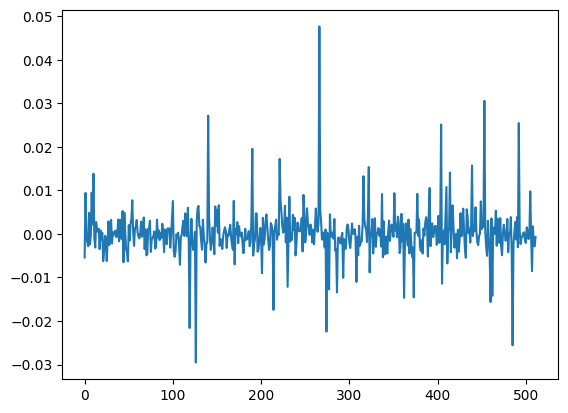

In [29]:
plt.plot(output[0].cpu().detach().numpy())

In [30]:
print(src.shape, angle.shape, tgt.shape)
print(angle)
# With target
output = model(src.unsqueeze(0), angle.unsqueeze(0))
output  = output.squeeze(0)
output.shape

torch.Size([2, 512]) torch.Size([]) torch.Size([2, 512])
tensor(0.7361, device='cuda:0')


torch.Size([3, 512])

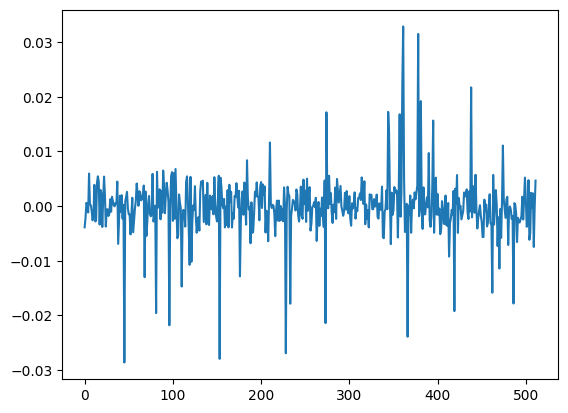

In [31]:
plt.plot(output[0].cpu().detach().numpy())

In [33]:
print(output.shape, tgt.shape)

torch.Size([3, 512]) torch.Size([2, 512])


In [34]:
print(test_loss_func(output[:-1,:], tgt))

tensor(0.9989, device='cuda:0', grad_fn=<MseLossBackward0>)
